# Feature Selection

This notebook implements ways to perform feature selection, a process of selecting a subset of the original features in a dataset to use in a machine learning model. The goal of feature selection is to improve model performance by reducing the number of irrelevant, redundant, or noisy features in the data.

---

First, load the relevant libraries needed.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set the Seaborn theme
sns.set_theme()
from matplotlib.colors import ListedColormap

# Import functions for feature selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## The Data

Theese algorithms will be implemented using the [Hawks](https://github.com/kary5678/INDE-577/blob/main/Data/hawks.csv) dataset. This dataset contains observations for three species of hawks, and attributes such as age, sex, wing length, body weight, tail length, etc. 

The code block below reads the dataset into a pandas DataFrame object, subsets the DataFrame to the relevant variables, and drops any rows where there are missing values for these relevant variables.

In [2]:
# Read in the data and subset it to the relevant columns/observations
hawks = pd.read_csv("../../Data/hawks.csv")
hawks = hawks[["Species", "Wing", "Tail", "Weight", "Culmen", "Hallux"]].dropna(axis=0)
hawks

,Species,Wing,Tail,Weight,Culmen,Hallux
0,RT,385.0,219,920.0,25.7,30.1
2,RT,381.0,235,990.0,26.7,31.3
3,CH,265.0,220,470.0,18.7,23.5
4,SS,205.0,157,170.0,12.5,14.3
5,RT,412.0,230,1090.0,28.5,32.2
...,...,...,...,...,...,...
903,RT,380.0,224,1525.0,26.0,27.6
904,SS,190.0,150,175.0,12.7,15.4
905,RT,360.0,211,790.0,21.9,27.6
906,RT,369.0,207,860.0,25.2,28.0


Since I'm going to be performing feature selection, I will consider all predictors of species as features.

In [3]:
# Data preparation step
X = hawks[["Wing", "Tail", "Weight", "Culmen", "Hallux"]]
y = hawks["Species"]

## Feature selection with RandomForestClassifier

Rrandom forests or decision trees can be used for feature selection by measuring the importance of each feature in the algorithm. I will look at the importance of each feature in my data and determine which aren't necessary to keep. Note that I implement this in depth in my [random forest notebook](https://github.com/kary5678/INDE-577/blob/main/supervised-learning/ensemble_methods/random_forests/random_forests.ipynb).


Here's a quick rundown of the steps to perform feature selection with `RandomForestClassifier`:

In [4]:
forest_model = RandomForestClassifier(
    max_depth = 3, n_estimators = 500, bootstrap = True, n_jobs = -1, random_state = 42)
forest_model.fit(X, y)

# Output each feature's importance
for ft, imp in zip(X.columns, forest_model.feature_importances_):
    print(f"{abs(imp):.3f} - {ft}")

0.196 - Wing
0.076 - Tail
0.247 - Weight
0.315 - Culmen
0.166 - Hallux


Tail length is obviously not an important feature. Culmen and weight have the highest feature importance, followed by wing and hallux length. Based on `SelectFromModel`, only culmen and weight are selected as important features.

In [5]:
trimmed_model = SelectFromModel(forest_model, prefit=True)
cols_keep = list(X.columns[trimmed_model.get_support()])
cols_drop = list(X.columns[~trimmed_model.get_support()])
print("Keeping:", cols_keep)
print("Dropping:", cols_drop)

Keeping: ['Weight', 'Culmen']
Dropping: ['Wing', 'Tail', 'Hallux']


## PCA: Principal Component Analysis

PCA is an unsupervised learning method for dimensionality reduction. It can reduce my five-dimensional data down to two dimensions for visualization. I implement PCA in depth in my PCA [subdirectory](https://github.com/kary5678/INDE-577/tree/main/unsupervised-learning/pca).

Here's a quick rundown of the steps to implement PCA:

In [6]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a PCA object with the desired number of components
pca = PCA(n_components=2)

# Fit the PCA object to the scaled data
pca.fit(X_scaled)

# Print the explained variance ratio of each principal component
print(pca.explained_variance_ratio_)

[0.80269141 0.15100066]


By using the weights below, the original 5D dataset is able to be reduced down to a 2D feature set.

In [7]:
pca.components_

array([[ 0.4842003 ,  0.46992847,  0.48030932,  0.48868016,  0.274248  ],
       [-0.13690084, -0.14333054, -0.13545933, -0.13303371,  0.96159623]])

Each row corresponds to a principal component, and the columns correspond to the original features in the dataset. The values in each row indicate the weight or importance of each feature in that component.

In other words, the larger the absolute value of a weight in a principal component, the more that feature contributes to that component. Higher values in pca.components_ can indicate more important variables, but it's important to note that the sign of the weight matters as well. Furthermore, the weights in pca.components_ are normalized, so they represent the direction of maximum variance in the data rather than the absolute importance of each feature.

In [8]:
# Transform the data to its principal components
X_transformed = pca.transform(X_scaled)
X_transformed.shape

(891, 2)

From the 5D feature set, we are now at a 2D feature set.

What does this look like with respect to the species in the data?

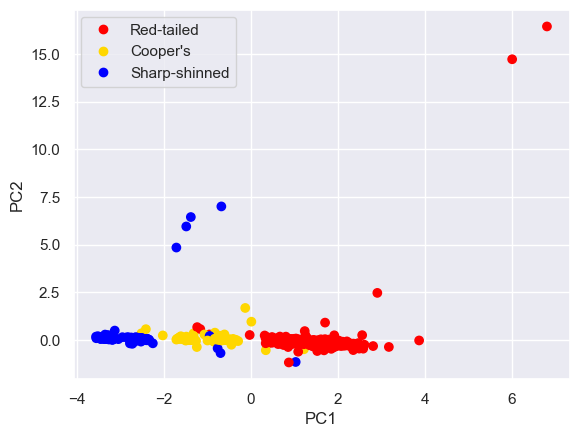

In [9]:
# Create a scatter plot using the first two principal components
species_colors = {"RT": 0, "CH": 1, "SS": 2}
colors = ["red", "gold", "blue"]
cmap = ListedColormap(colors)

scatter = plt.scatter(X_transformed[:,0], X_transformed[:,1], c = [species_colors[hawk] for hawk in y], cmap = cmap)
plt.legend(handles = scatter.legend_elements()[0], labels=["Red-tailed", "Cooper's", "Sharp-shinned"])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

As we've reduced the 5 predictor feature set down to a 2-dimensional space, fitted models will become less complex!

## Summary

Feature selection is an important step in preparing data for machine learning. It can improve model performance, reduce complexity, and increase interpretability, while also making the model more efficient and easier to work with. In the above two examples, I went from a five-dimensional predictor set to a two-dimensional one that is still representative of the trends in the data, meaning that model performance is maintained while model complexity drastically decreases.